# Circuit learning module: Lambeq's QuantumTrainer

This module performs the optimization with Lambeq's native optimizer. Because the circuits are constructed with Lambeq and DisCoPy, this optimizer is the natural choice. The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline.ipynb.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
import numpy as np
import pickle

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"
small = True

BATCH_SIZE = 32
EPOCHS = 100
SEED = 0

## Read circuit data

We read the circuits from the pickled files.

In [2]:
training_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//training//[0-9]*.p")
validation_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//validation//[0-9]*.p")
test_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//test//[0-9]*.p")

training_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//small//circuits//binary_classification//training//[0-9]*.p")
validation_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//small//circuits//binary_classification//validation//[0-9]*.p")
test_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//small//circuits//binary_classification//test//[0-9]*.p")

def read_diagrams(circuit_paths):
    circuits = {}
    for serialized_diagram in circuit_paths:
        base_name = Path(serialized_diagram).stem
        f = open(serialized_diagram, "rb")
        diagram = pickle.load(f)
        circuits[base_name] = diagram
    return circuits


training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [3]:
training_data, test_data, validation_data = None, None, None
if small:
    with open(this_folder + "//data//small//training_data.json", "r") as inputfile:
        training_data = json.load(inputfile)['training_data']
    with open(this_folder + "//data//small//test_data.json", "r") as inputfile:
        test_data = json.load(inputfile)['test_data']
    with open(this_folder + "//data//small//validation_data.json", "r") as inputfile:
        validation_data = json.load(inputfile)['validation_data']
else:
    with open(this_folder + "//data//training_data.json", "r") as inputfile:
        training_data = json.load(inputfile)['training_data']
    with open(this_folder + "//data//test_data.json", "r") as inputfile:
        test_data = json.load(inputfile)['test_data']
    with open(this_folder + "//data//validation_data.json", "r") as inputfile:
        validation_data = json.load(inputfile)['validation_data']
    

def time_to_states(data, circuits):
    labeled_data = {}
    for elem in data:
        if elem["name"] in circuits.keys():
            if elem["time"] < 5000:
                labeled_data[elem["name"]] = [1,0] # corresponds to |0>
            else:
                labeled_data[elem["name"]] = [0,1] # corresponds to |1>
    return labeled_data


training_data_labels = time_to_states(training_data, training_circuits)
test_data_labels = time_to_states(test_data, test_circuits)
validation_data_labels = time_to_states(validation_data, validation_circuits)

#for key in training_data_labels:
#    print("training: ", key)
#for key in test_data_labels:
#    print("test ", key)

## Lambeq optimizer

In [5]:
#all_circuits = list(training_circuits.values()) + list(test_circuits.values())

training_circuits_l = []
test_circuits_l = []
validation_circuits_l = []

training_data_labels_l = []
test_data_labels_l = []
validation_data_labels_l = []

# Organize circuits and labels in correct order into two lists which will be input for training the model
for key in training_data_labels:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_data_labels:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])
    
for key in validation_data_labels:
    validation_circuits_l.append(validation_circuits[key])
    validation_data_labels_l.append(validation_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l + validation_circuits_l

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])
val_syms = set([sym for circuit in validation_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered: ", test_syms.difference(train_syms))
print("Validation circuits need to share training circuits' parameters. The parameters that are not covered: ", val_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len(train_syms))

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 32768
}

Test circuits need to share training circuits' parameters. The parameters that are not covered:  set()
Validation circuits need to share training circuits' parameters. The parameters that are not covered:  set()
Total number of circuits:  29
Total number of variables:  76


## Model

Select the used model between `TketModel` or `NumpyModel`. `NumpyModel` can use JAX which speeds up the training.

In [6]:
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)
#model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
model.initialise_weights()

## Loss function and evaluation

In [7]:
def acc(y_hat, y):
    return (np.sum(np.round(y_hat) == y) / len(y)) / 2

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)

eval_metrics = {"acc": acc}

## Trainer

In [8]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 1, 'c': 0.1, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

## Training dataset

In [9]:
train_dataset = Dataset(training_circuits_l, training_data_labels_l)
val_dataset = Dataset(validation_circuits_l, validation_data_labels_l, shuffle=False)

#test_dataset = Dataset(test_circuits_l, test_data_labels_l, shuffle=False)

trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=1)

Epoch 1:    train/loss: 0.3923   valid/loss: 0.5643   train/acc: 0.6053   valid/acc: 0.7000
Epoch 2:    train/loss: 1.9376   valid/loss: 0.7871   train/acc: 0.7105   valid/acc: 0.5000
Epoch 3:    train/loss: 0.8051   valid/loss: 0.4159   train/acc: 0.7105   valid/acc: 0.7000
Epoch 4:    train/loss: 0.3359   valid/loss: 0.6222   train/acc: 0.6842   valid/acc: 0.6000
Epoch 5:    train/loss: 1.5770   valid/loss: 3.0459   train/acc: 0.5263   valid/acc: 0.8000
Epoch 6:    train/loss: 0.1291   valid/loss: 2.9545   train/acc: 0.9737   valid/acc: 0.7000
Epoch 7:    train/loss: 0.7102   valid/loss: 3.0089   train/acc: 0.8684   valid/acc: 0.7000
Epoch 8:    train/loss: 1.7100   valid/loss: 9.5407   train/acc: 0.3947   valid/acc: 0.3000
Epoch 9:    train/loss: 6.4285   valid/loss: 3.4515   train/acc: 0.2105   valid/acc: 0.4000
Epoch 10:   train/loss: 1.9101   valid/loss: 0.6121   train/acc: 0.5000   valid/acc: 0.6000
Epoch 11:   train/loss: 1.3710   valid/loss: 0.5862   train/acc: 0.4211   valid/

[2.55999869e-07 9.99999744e-01]
[0.33333335 0.66666665]
[0.40000004 0.59999996]
[0.36363639 0.63636361]
[0.17647063 0.82352937]
[1, 0]
[1, 0]
[0, 1]
[1, 0]
[1, 0]
Validation accuracy: 0.4


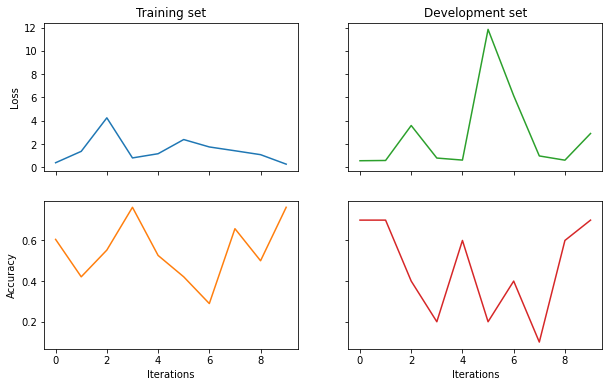

In [10]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

for e in model(test_circuits_l):
    print(e)
for e in test_data_labels_l:
    print(e)

# print test accuracy
test_acc = acc(model(test_circuits_l), test_data_labels_l)
print('Test accuracy:', test_acc.item())